<a href="https://colab.research.google.com/github/oliverwsd/Deep-Portfolio/blob/master/LTSM_ph_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# Run some setup code for this notebook.
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from keras.layers import Input, Dense, Dropout,LSTM,Activation
from keras.models import Model
from keras.models import Sequential
from keras import regularizers
from keras.constraints import maxnorm
from keras.models import load_model
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler  
from collections import defaultdict

matplotlib.rcParams[ 'figure.figsize' ] = ( 20, 6 )


#packages for modelling
import tensorflow.compat.v1 as tfo
import tensorflow as tf
import random as rd
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import GridSearchCV
from scipy.stats import reciprocal

#packages for plotting
%matplotlib inline
import matplotlib.dates as md
import pydot

#packages for extraction and saving data
import os
import glob as glob
import csv

#packages for date handling
import datetime
from time import time

In [10]:
# preparing data for LSTMs
# we consider an embedding layer instead of feeding the entire seires into the model at once
# therefore we split data into smaller peices in an constant window to create a smaller seires of observertion for prediction

def normalize_data(X, Y, LOOKBACK_WINDOW):
    _X = X.dropna()
    _Xs = []
    _Ys = []
    for i in range(_X.shape[0] - LOOKBACK_WINDOW):
        cur_X = _X.values[i:i + LOOKBACK_WINDOW]
        _Xs.append(cur_X)
        
        y_pointer = i + LOOKBACK_WINDOW
        cur_Y = Y.values[y_pointer]
        _Ys.append(cur_Y)
    return np.array(_Xs), np.array(_Ys)

In [11]:
from io import StringIO
import csv
# realized variance 
train_data = 'https://raw.githubusercontent.com/oliverwsd/Deep-Portfolio/master/ph_train.csv'
test_data = 'https://raw.githubusercontent.com/oliverwsd/Deep-Portfolio/master/ph_test.csv'

# read csv
x = pd.read_csv(train_data, index_col=0)
y = pd.read_csv(test_data, index_col=0)

In [12]:
# x: volatilities of selected 50 stocks in the last 100 days
# y: market volatility in 101th day 
x_train, y_train = normalize_data(x, x, 100)
x_test, y_test = normalize_data(y,y,100)
# Split the data into a training and test set
# We are using 80 percent of the data as training set and 20% as the test set. 

In [13]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))

nsamples, nx, ny = x_train.shape
d2_x_train = x_train.reshape((nsamples,nx*ny))
d2_x_train_scaled = sc.fit_transform(d2_x_train)
x_train_scaled = d2_x_train_scaled.reshape(nsamples,nx,ny)
# x_train_scaled.shape

nsamples, nx, ny = x_test.shape
d2_x_test = x_test.reshape((nsamples,nx*ny))
d2_x_test_scaled = sc.fit_transform(d2_x_test)
x_test_scaled = d2_x_test_scaled.reshape(nsamples,nx,ny)
# x_test_scaled.shape

y_train_scaled = sc.fit_transform(y_train)

In [14]:
x_train_scaled.shape

(1012, 100, 1)

In [15]:
y_train_scaled.shape

(1012, 1)

In [19]:
# one-to-one LSTM for sequence prediction
# length = x_train_scaled.shape[0]
# n_neurons = length

model = Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=(x_train_scaled.shape[1], x_train_scaled.shape[2])))
model.add(Dropout(0.2))
# model.add(LSTM(units=64, return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dropout(0.2))
model.add(Dense(units = 1))
model.add(Activation('linear'))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100, 32)           4352      
_________________________________________________________________
dropout_4 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 29,249
Trainable params: 29,249
Non-trainable params: 0
__________________________________________________

In [ ]:
model.fit(x_train_scaled, y_train_scaled, epochs = 100, batch_size = 40, validation_split=0.1)

Epoch 1/500
64/64 [==============================] - 12s 182ms/step - loss: 0.0026
Epoch 2/500
64/64 [==============================] - 12s 185ms/step - loss: 0.0026
Epoch 3/500
64/64 [==============================] - 12s 186ms/step - loss: 0.0025
Epoch 4/500
64/64 [==============================] - 12s 184ms/step - loss: 0.0027
Epoch 5/500
64/64 [==============================] - 12s 185ms/step - loss: 0.0027
Epoch 6/500
64/64 [==============================] - 12s 187ms/step - loss: 0.0026
Epoch 7/500
64/64 [==============================] - 12s 188ms/step - loss: 0.0026
Epoch 8/500
64/64 [==============================] - 12s 186ms/step - loss: 0.0023
Epoch 9/500
64/64 [==============================] - 12s 185ms/step - loss: 0.0027
Epoch 10/500
64/64 [==============================] - 12s 183ms/step - loss: 0.0025
Epoch 11/500
64/64 [==============================] - 12s 180ms/step - loss: 0.0023
Epoch 12/500
64/64 [==============================] - 12s 185ms/step - loss: 0.0025
E

KeyboardInterrupt: ignored

In [27]:
model.save('ltsm_ph.h5')

In [34]:
predictions = model.predict(x_test_scaled)
predictions = sc.inverse_transform(predictions)

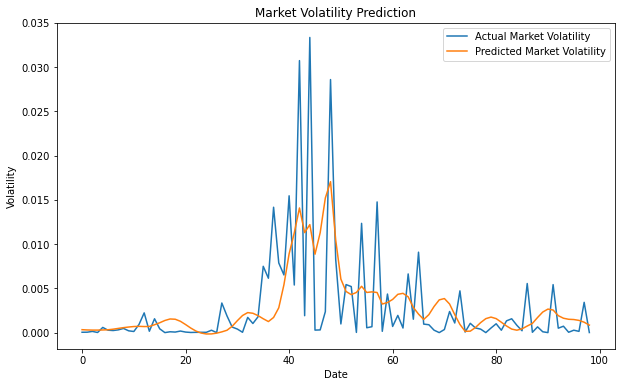

In [35]:
plt.figure(figsize=(10,6))
plt.plot(y_test, label='Actual Market Volatility')
plt.plot(predictions, label='Predicted Market Volatility')
plt.title('Market Volatility Prediction')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()